## Modelagem de Dispersão
Neste notebook vamos implementar um modelo de dispersão Gaussiano 

In [57]:
import pandas as pd
import numpy as np

# Gerar um intervalo de datas para o ano de 2023
datas = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# Criar DataFrame com as datas
df = pd.DataFrame({'Data': datas})

# Extrair os meses das datas e adicioná-los como uma nova coluna no DataFrame
df['Mes'] = df['Data'].dt.month

# Extrair o dia do ano das datas e adicioná-lo como uma nova coluna no DataFrame
df['Dia_do_Ano'] = df['Data'].dt.dayofyear

# Expandir as datas para incluir as horas do dia (1 a 24)
df_expandido = df.loc[df.index.repeat(24)].reset_index(drop=True)
df_expandido['Hora_Dia'] = [hora for _ in range(len(df)) for hora in range(1, 25)]



In [58]:
# Parâmetros de aleatoriedade para radiação, cobertura de nuvens e velocidade do vento
radMax = 1000
radMin = 1

cobertura_de_nuvensMax = 100
cobertura_de_nuvensMin = 0

veloc_ventoMax = 11.31
veloc_ventoMin = 0

# Número de linhas/número de datas
n = df_expandido.shape[0]

# Criar valores aleatórios
radiacao = (radMax - radMin) * np.random.rand(n) + radMin
cobertura_de_nuvens = (cobertura_de_nuvensMax - cobertura_de_nuvensMin) * np.random.rand(n) + cobertura_de_nuvensMin
veloc_vento = (veloc_ventoMax - veloc_ventoMin) * np.random.rand(n) + veloc_ventoMin

# Adicionar as colunas ao DataFrame
df_expandido['Radiacao'] = radiacao
df_expandido['Cobertura_de_Nuvens'] = cobertura_de_nuvens
df_expandido['Veloc_Vento'] = veloc_vento

In [60]:
# Função para determinar a classe de estabilidade
def classe_estabilidade(hora_dia, radiacao, cobertura_de_nuvens, veloc_vento):
    if hora_dia < 6 or hora_dia >= 18:
        # Condições noturnas
        if cobertura_de_nuvens >= 5:
            if 2 <= veloc_vento <= 3:
                return "E"
            else:
                return "D"
        else:
            if 2 <= veloc_vento < 3:
                return "F"
            elif 3 <= veloc_vento <= 5:
                return "E"
            else:
                return "D"
    else:
        # Condições diurnas
        if radiacao > 700:  # Radiação solar forte
            if veloc_vento < 2:
                return "A"
            elif 2 <= veloc_vento <= 5:
                return "B"
            else:
                return "C"
        elif 350 <= radiacao <= 700:  # Radiação solar moderada
            if veloc_vento < 3:
                return "B"
            elif 3 < veloc_vento <= 5:
                return "C"
            else:
                return "D"
        else:  # Radiação solar fraca
            if veloc_vento < 2:
                return "B"
            elif 2 <= veloc_vento <= 3:
                return "C"
            elif 3 < veloc_vento <= 5:
                return "C"
            elif 5 < veloc_vento <= 6:
                return "C"
            else:
                return "D"

# Aplicar a função para cada linha do DataFrame
df_expandido['Classe_Estabilidade'] = df_expandido.apply(
    lambda row: classe_estabilidade(
        row['Hora_Dia'],
        row['Radiacao'],
        row['Cobertura_de_Nuvens'],
        row['Veloc_Vento']
    ), axis=1
)

# Verificar o DataFrame expandido
print(df_expandido)

# Salvar o DataFrame em um arquivo CSV
df.to_csv(r'C:\Users\Carlos Suganuma - VB\Documents\GitHub\ENS5173_202401\tabelas\estabilidade.csv')


           Data  Mes  Dia_do_Ano  Hora_Dia    Radiacao  Cobertura_de_Nuvens  \
0    2023-01-01    1           1         1  131.222696            47.242427   
1    2023-01-01    1           1         2  966.326846            71.200212   
2    2023-01-01    1           1         3  958.906667             3.439715   
3    2023-01-01    1           1         4  677.611884            87.919362   
4    2023-01-01    1           1         5  905.789617            14.261488   
...         ...  ...         ...       ...         ...                  ...   
8755 2023-12-31   12         365        20  199.817130             6.005532   
8756 2023-12-31   12         365        21  404.077421            91.275234   
8757 2023-12-31   12         365        22  512.060029            76.252149   
8758 2023-12-31   12         365        23  843.793179            12.641123   
8759 2023-12-31   12         365        24  984.789494            39.841310   

      Veloc_Vento Classe_Estabilidade  
0        1.

In [38]:
# criando uma função do modelo gaussiano 
import numpy as np # trabalhar com pi 
def modeloGaussiano (qs, sigmaY, sigmaZ, u, y, z, H):
    termo1 = qs/(2*np.pi*sigmaY*sigmaZ*u)
    termo2 = np.exp((-y**2)/(2*sigmaY**2))
    termo3 = np.exp((-(z - H)**2)/(2*sigmaZ**2)) + np.exp((-(z + H)**2)/(2*sigmaZ**2)) # termo de reflexão da pluma + e -
    conc = termo1*termo2*termo3 
    conc 
    return conc


In [39]:
# Criando função da estimativa da dispersão lateral e vertical da pluma
# Fórmulação de Brigs, classe Pasquil

def sigmaXY(x,classe,urbOrRural):
    if urbOrRural=='urbano':
        if (classe=='A') or (classe=='B'):
            sigmaY = 0.32*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.24*x*(1+0.001*x)**(0.5)
        elif (classe=='C'):
            sigmaY = 0.22*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.20*x
        elif (classe=='D'):
            sigmaY = 0.16*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.14*x*(1+0.0003*x)**(-0.5)
        elif (classe=='E') or (classe=='F'):
            sigmaY = 0.11*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.08*x*(1+0.0015*x)**(-0.5) 
        else:
            print('Classe de estabilidade errada')
    if urbOrRural=='rural':
        if (classe=='A') :
            sigmaY = 0.22*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.20*x
        elif (classe=='B') :
            sigmaY = 0.16*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.12*x
        elif (classe=='C') :
            sigmaY = 0.11*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.08*x*(1+0.0002*x)**(-0.5)
        elif (classe=='D') :
            sigmaY = 0.08*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.06*x*(1+0.0015*x)**(-0.5)
        elif (classe=='E') :
            sigmaY = 0.06*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.03*x*(1+0.0003*x)**(-1)
        elif (classe=='F') :
            sigmaY = 0.04*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.016*x*(1+0.0003*x)**(-1)
        else:
            print('Classe de estabilidade errada. Fique ligado')
    return sigmaY,sigmaZ

In [40]:
# Função para estimar o deltaH com base na equação de Davidson-Bryant
def deltaHdavidsonBryant(d,vs,u,Ts,Tamb):
    deltaH = (d*(vs/u)**(1.4))*(1+(Ts-Tamb)/Ts)
    return deltaH

In [41]:
# Utilizando a função do modelo gaussiano, definindo valores 
qs = 100 # g/s
sigmaY = 10 # m # apagar depois os sigmas, queremos q ele seja gerado 
sigmaZ = 15 # m 
u = 10 # m/s 
y = 0 # estimando na direção do vento, na direção de x, por isso y=0 
z = 1.5 # altura do nariz
H = 50 # m, altura da chaminé

# Chamando a função do modelo gaussiano 
conc = modeloGaussiano(qs, sigmaY, sigmaZ, u, y, z, H) 

print("A concentração estimada é = " +str(conc)+'[$\mu$]g/m') 

A concentração estimada é = 8.62052564132534e-05[$\mu$]g/m


deltaH = 2.700592857381857
A pluma subiu


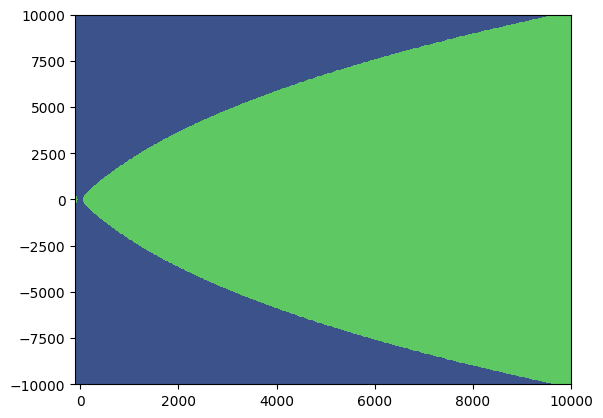

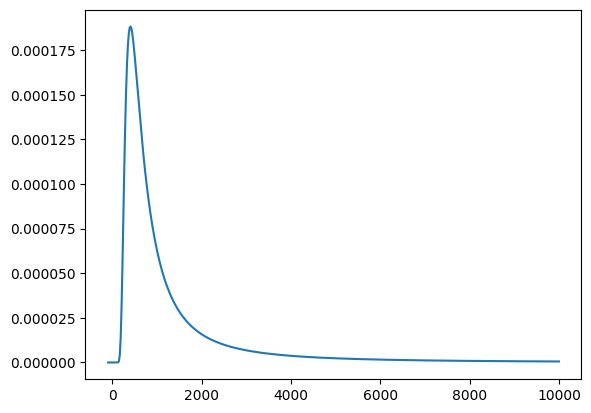

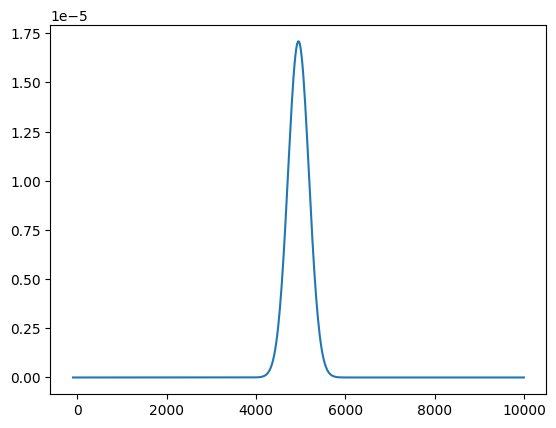

In [42]:
#Criando Domínio de modelagem, vetor 
x = np.linspace(-100,10000,500)
y = np.linspace(-10000,10000,500)

#transformando os vetores em matrizes de x e y 
xx, yy = np.meshgrid(x,y)

# Adotando inputs
classe = 'A'
urbOrRural = 'urbano' 
hg = 150 # m altura geométrica da chaminé
qs = 100 # g/s
sigmaY = 10 # m
sigmaZ = 15 # m
u = 5 # m/s
y = 0 # estimando na direção do vento
z = 1.5 # altura do nariz
d = 1 # em metros
vs = 10 # em m/s
Ts = 300 # em Kelvin
Tamb = 293 # em Kelvin

# Estimando o coeficiente de dispersão lateral e vertical
sigmaY,sigmaZ = sigmaXY(xx,classe,urbOrRural)
#print(sigmaY)

if vs>1.5*u:
    # Estimando a sobrelevação da pluma (deltaH)
    deltaH = deltaHdavidsonBryant(d,vs,u,Ts,Tamb)
    print('deltaH = '+str(deltaH))
    hef = hg+deltaH
    print('A pluma subiu')
else:
    hef = hg +2*d*((vs/u)-1.5)
    print('A pluma caiu')

# Utilizando a matriz de yy como input na função do modelo gaussiano
conc = modeloGaussiano(qs,sigmaY,sigmaZ,u,yy,z,hef)

# Visualização dos resultados no espaço
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig,ax = plt.subplots()
ax.contourf(xx,yy,conc+0.1,norm = LogNorm())

# Corte em y - sobre o eixo x
fig,ax = plt.subplots()
ax.plot(x,conc[250,:])

# Corte em x - sobre o eixo y 
fig,ax = plt.subplots()
ax.plot(x,conc[:,100])



